In [1]:
import anndata
import numpy as np
import pandas as pd
import scanpy as sc

from sklearn.metrics import adjusted_rand_score

In [2]:
map_info = pd.read_csv('/lmh_data/data/sclab/sclab/map_result.csv', sep='\t', index_col=0)
map_info

,scHiC,cell_type
AAACCCACAGTGAGCA-LKTX_190129_01_A01,190305_29yr_2_F2_AD012_ODC,ODC
AAAGGTATCGGCTGGT-LKTX_190129_01_A01,181218_21yr_3_H5_AD007_ODC,ODC
AATCACGAGAGTCCGA-LKTX_190129_01_A01,190305_21yr_2_E12_AD008_ODC,ODC
AATCGACGTGAGCCAA-LKTX_190129_01_A01,190315_29yr_6_C7_AD002_ODC,ODC
AATGGAAAGTCGAGGT-LKTX_190129_01_A01,190315_21yr_6_A5_AD012_ODC,ODC
...,...,...
ACGTTCCAGTGAACAT-LKTX_190130_01_H01,190315_21yr_6_B11_AD008_Endo,Endo
GAGAAATGTCTCAGGC-LKTX_190130_01_H01,181218_21yr_2_E4_AD004_Endo,Endo
GATTCTTTCTTCCTAA-LKTX_190130_01_H01,190305_29yr_2_E8_AD012_Endo,Endo
GTCGCGAGTGAGAGGG-LKTX_190130_01_H01,181218_21yr_3_A5_AD008_Endo,Endo


In [3]:
rna = anndata.read_h5ad("/lmh_data/data/sclab/sclab/rna_result.h5ad")
hic = anndata.read_h5ad("/lmh_data/data/sclab/sclab/hic_result.h5ad")
eval_dataset = np.load('/lmh_data/data/sclab/sclab/eval_dataset.npy', allow_pickle=True)

In [4]:
map_rna_names, map_hic_names = [], []
truth_nums = 0
for _data in eval_dataset:
    if _data['identity'] != 'truth':
        continue
    if _data['cell_type'] not in ['Astro', 'OPC', 'ODC']:
        continue
    truth_nums += 1
    for i in range(rna.X.shape[0]):
        if np.array_equal(rna.layers['counts'][i].astype(np.int32), _data['scRNA']):
            map_rna_names.append(rna[i].obs_names[0])
            map_hic_names.append(map_info.loc[rna[i].obs_names[0], 'scHiC'])

if truth_nums != len(map_rna_names):
    print('error')

In [5]:
rna[map_rna_names]

View of AnnData object with n_obs × n_vars = 300 × 29175
    obs: 'cell_type', 'domain', 'leiden', 'balancing_weight'
    var: 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'transcript_id', 'gene_type', 'gene_status', 'transcript_type', 'transcript_status', 'transcript_name', 'havana_gene', 'tag', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: '__scglue__', 'cell_type_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_glue', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [6]:
hic[map_hic_names]

View of AnnData object with n_obs × n_vars = 300 × 309581
    obs: 'domain', 'cell_type', 'leiden', 'balancing_weight'
    var: 'chrom', 'start', 'chromStart', 'chromEnd', 'highly_variable'
    uns: '__scglue__', 'cell_type_colors', 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_glue', 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


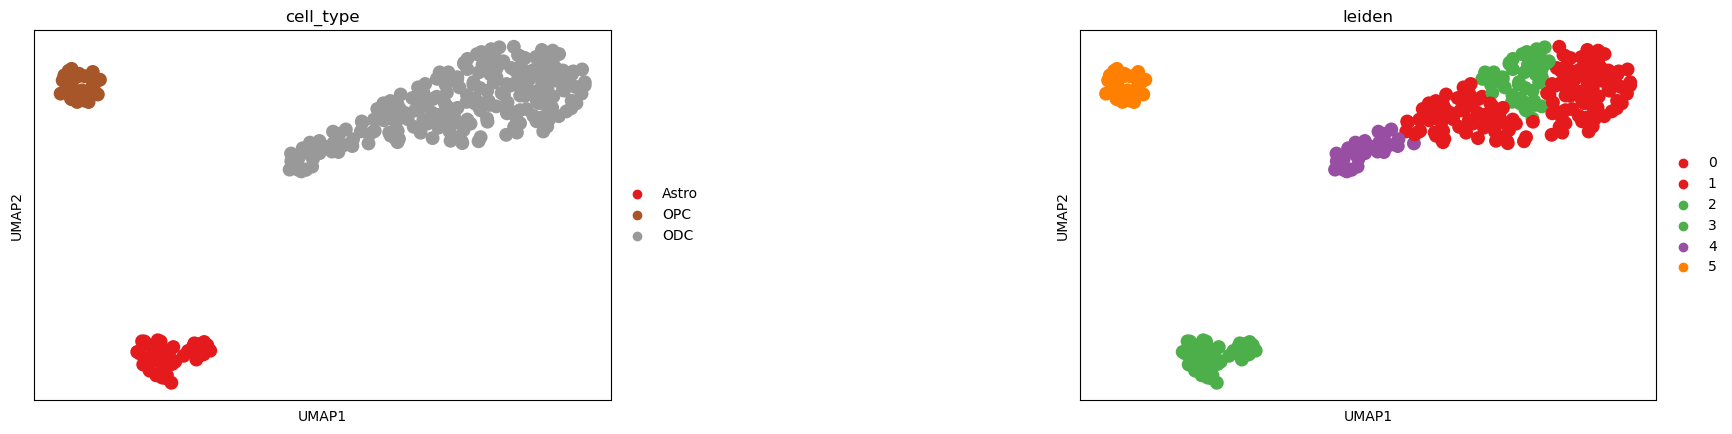

In [7]:
_rna = rna[map_rna_names].copy()
sc.tl.pca(_rna, n_comps=10, svd_solver="auto")
sc.pp.neighbors(_rna, use_rep="X_pca", metric="cosine")
sc.tl.umap(_rna)
sc.tl.leiden(_rna)
sc.pl.umap(_rna, color=['cell_type', 'leiden'], wspace=0.65)

/root/miniconda3/envs/see/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


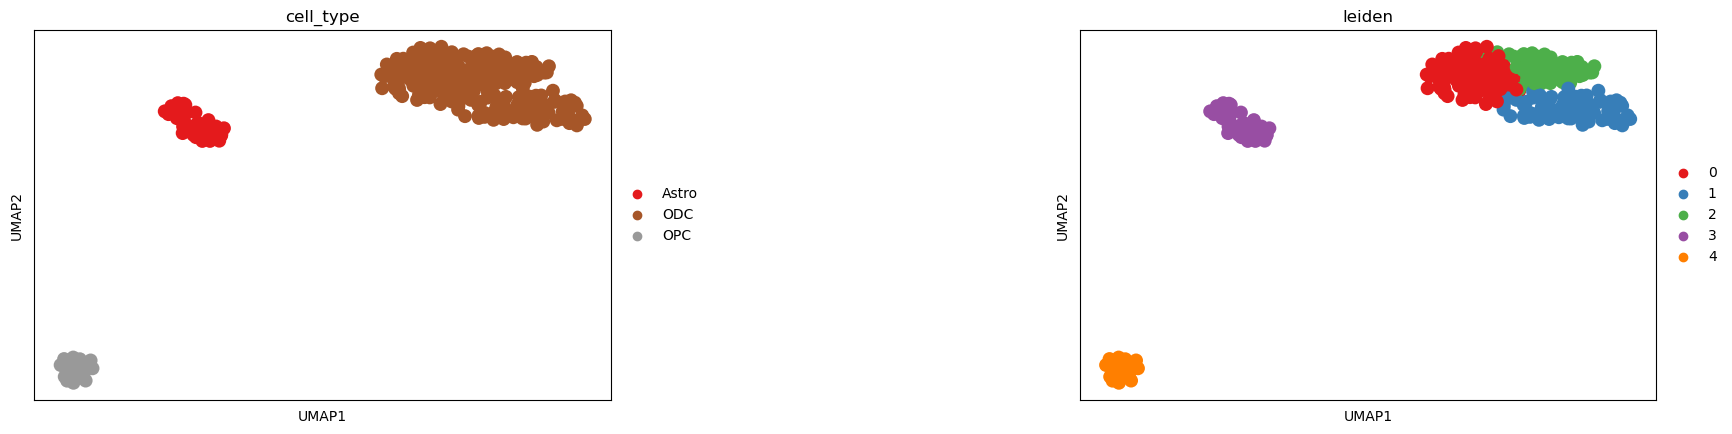

In [8]:
_hic = hic[map_hic_names].copy()
sc.tl.pca(_rna, n_comps=10, svd_solver="auto")
sc.pp.neighbors(_hic, use_rep="X_pca", metric="cosine")
sc.tl.umap(_hic)
sc.tl.leiden(_hic)
sc.pl.umap(_hic, color=['cell_type', 'leiden'], wspace=0.65)

In [9]:
def cal_ARI(predict_path):
    preds = np.load(predict_path, allow_pickle=True)

    results, cell_types = [], []
    for i in range(len(preds)):
        if eval_dataset[i]['identity'] != 'truth':
            continue
        if eval_dataset[i]['cell_type'] not in ['Astro', 'OPC', 'ODC']:
            continue
        _pred = preds[i]['predict']
        results.append(_pred)
        cell_types.append(eval_dataset[i]['cell_type'])
    results, cell_types = np.array(results), np.array(cell_types)

    results = anndata.AnnData(X = results)
    results.obs['cell_type'] = cell_types
    sc.tl.pca(results, n_comps=10, svd_solver="auto")
    sc.pp.neighbors(results, metric="cosine")
    sc.tl.umap(results)
    sc.tl.leiden(results)
    sc.pl.umap(results, color=['cell_type', 'leiden'], wspace=0.65)

    return adjusted_rand_score(
        [int(i) for i in _rna.obs['leiden'].values],
        [int(i) for i in results.obs['leiden'].values]
    )

/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


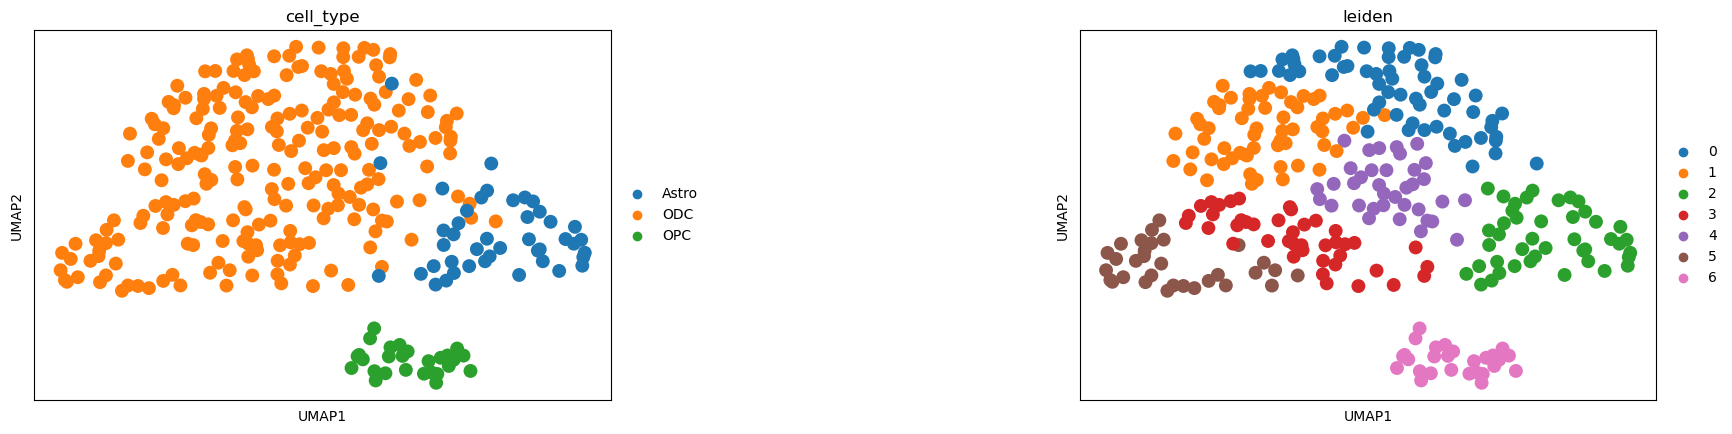

/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


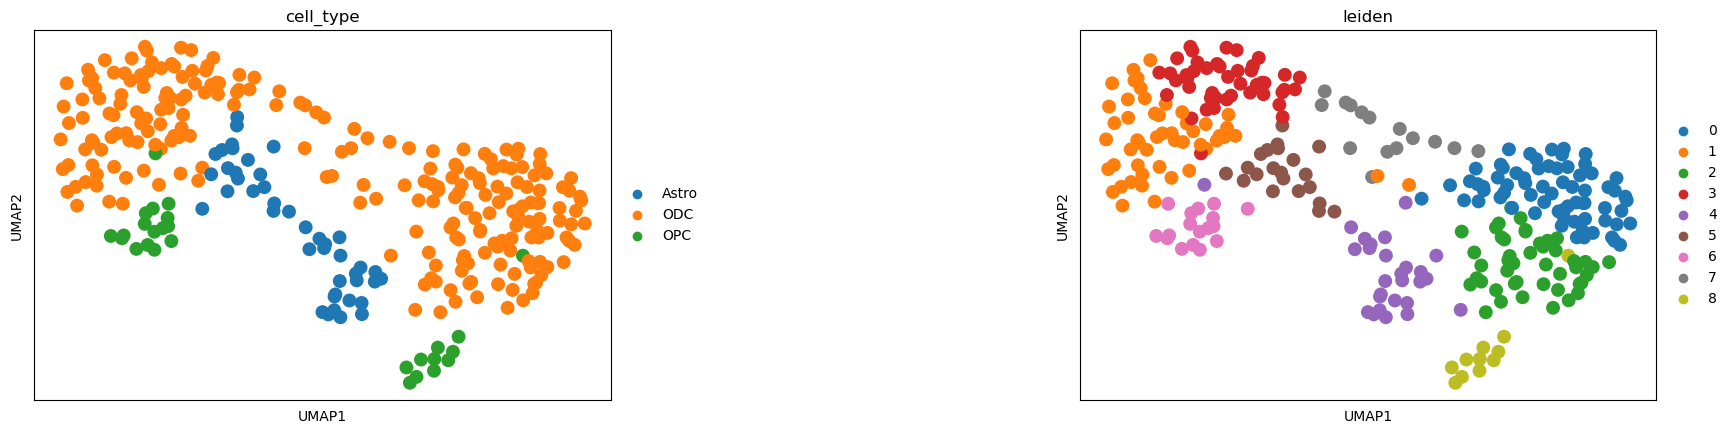

/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/see/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


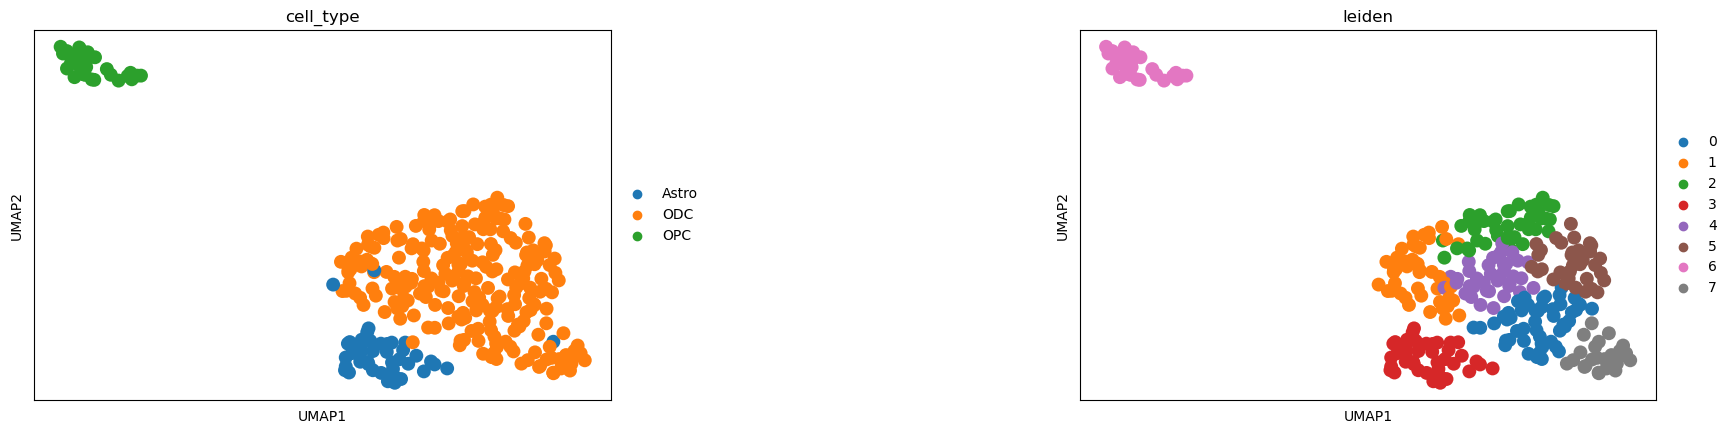

In [10]:
ARI = dict(
    CONTROL = adjusted_rand_score(
        [int(i) for i in _rna.obs['leiden'].values],
        [int(i) for i in _hic.obs['leiden'].values]
    ),
    PDGFRA = cal_ARI('/lmh_data/data/sclab/sclab/tmp/PDGFRA/evaluate.npy'),
    MBP = cal_ARI('/lmh_data/data/sclab/sclab/tmp/MBP/evaluate.npy'),
#     SLC1A2 = cal_ARI('/lmh_data/data/sclab/sclab/tmp/SLC1A2/evaluate.npy'),
    SLC1A3 = cal_ARI('/lmh_data/data/sclab/sclab/tmp/SLC1A3/evaluate.npy'),
#     GPM6A = cal_ARI('/lmh_data/data/sclab/sclab/tmp/GPM6A/evaluate.npy'),
)

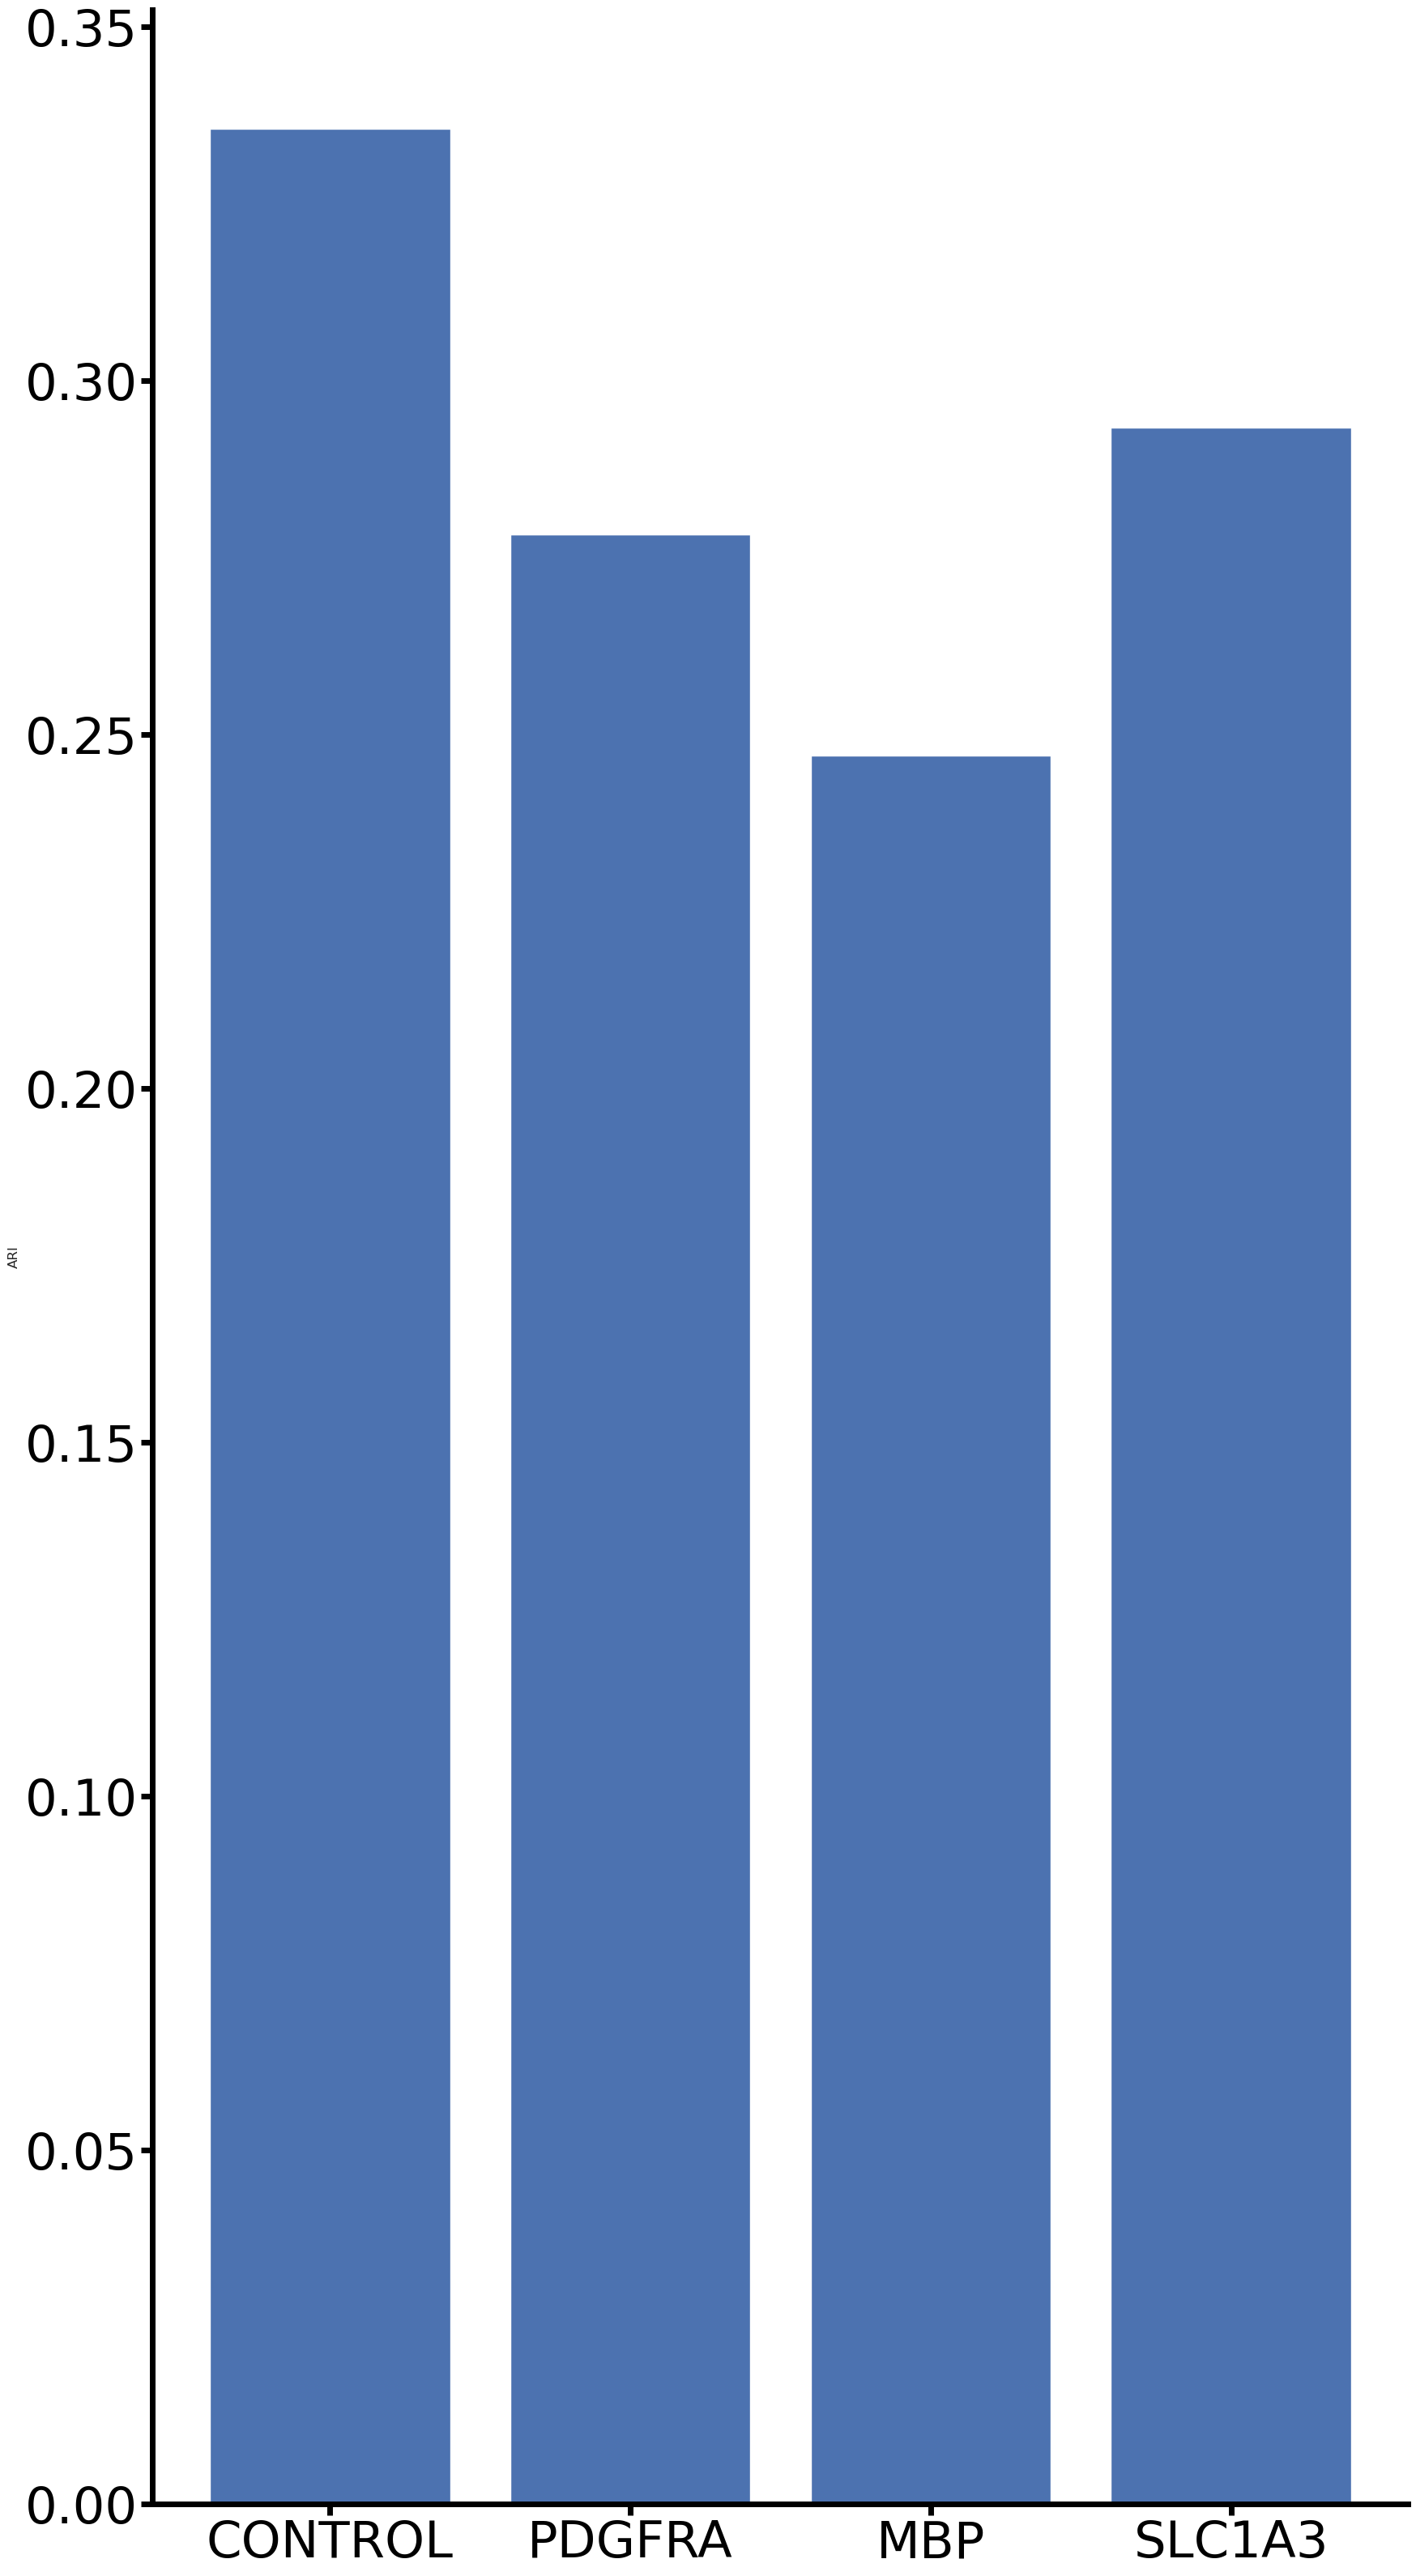

In [11]:
import sys
sys.path.append('/lmh_data/work/SEE/analyse/')

import matplotlib.pyplot as plt
import seaborn as sns
from analyse_util import figure_size, set_plt, set_Border

set_plt(figsize=(20, 40))
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots()

plt.bar(ARI.keys(), ARI.values())
plt.ylabel('ARI')

set_Border(plt.gca())
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])
plt.grid(False)

plt.savefig('/lmh_data/work/SEE/analyse/figure_file/ARI.pdf', format='pdf', bbox_inches='tight')
plt.show()